In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter
import skimage as ski

In [7]:
class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n
    
    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
    
    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        
        if root_x == root_y:
            return root_x
        
        # Union by rank
        if self.rank[root_x] < self.rank[root_y]:
            self.parent[root_x] = root_y
            return root_y
        elif self.rank[root_x] > self.rank[root_y]:
            self.parent[root_y] = root_x
            return root_x
        else:
            self.parent[root_y] = root_x
            self.rank[root_x] += 1
            return root_x

In [8]:
class FelzenszwalbSegmentation:
    def __init__(self, image, sigma=0.8, k=300, min_size=50):
     
        self.image = image
        self.sigma = sigma  #standard deviation for Gaussian smoothing
        self.k = k          #scale parameter (larger = larger segments)
        self.min_size = min_size
        self.height, self.width = image.shape[:2]
        self.num_pixels = self.height * self.width
        
    def segment(self):
        smoothed = self._smooth_image()
        edges = self._build_graph(smoothed) # Build graph from image
        edges.sort(key=lambda x: x[2])  # Sort edges by weight
        components = self._segment_graph(edges) # Segment graph
        components = self._remove_small_components(components)  # Post-process small components
        return components
    
    def _smooth_image(self):
        if len(self.image.shape) == 3:
            gray = rgb2gray(self.image)
        else:
            gray = self.image

        if self.sigma > 0:
            return gaussian_filter(gray.astype(float), sigma=self.sigma)
        
        return gray.astype(float)
    
    def _build_graph(self, image):
        edges = []

        def node_id(y, x):
            return y * self.width + x
        
        for y in range(self.height):
            for x in range(self.width):
                current_id = node_id(y, x)
                current_val = image[y, x]
                
                # Right neighbor
                if x + 1 < self.width:
                    right_id = node_id(y, x + 1)
                    right_val = image[y, x + 1]
                    weight = abs(float(current_val) - float(right_val))
                    edges.append((current_id, right_id, weight))
                
                # Down neighbor
                if y + 1 < self.height:
                    down_id = node_id(y + 1, x)
                    down_val = image[y + 1, x]
                    weight = abs(float(current_val) - float(down_val))
                    edges.append((current_id, down_id, weight))
        
        return edges
    
    def _segment_graph(self, edges):
        uf = UnionFind(self.num_pixels)
        internal_diff = [0] * self.num_pixels
        comp_size = [1] * self.num_pixels 
        
        for edge in edges:
            a, b, weight = edge
            
            root_a = uf.find(a)
            root_b = uf.find(b)
            
            if root_a == root_b:
                continue
            
            tau_a = self.k / comp_size[root_a]   # τ(C) = k / |C|
            tau_b = self.k / comp_size[root_b]
            
            # MInt(C1, C2) = min( Int(C1) + τ(C1), Int(C2) + τ(C2) )
            m_int = min(internal_diff[root_a] + tau_a,
                       internal_diff[root_b] + tau_b)
            
            # Merge if weight <= MInt
            if weight <= m_int:
                # Merge components
                new_root = uf.union(root_a, root_b)
                old_root = root_b if new_root == root_a else root_a
                
                # Update component size
                new_size = comp_size[root_a] + comp_size[root_b]
                comp_size[new_root] = new_size
                
                # Update internal difference = max(current weight, previous internal diffs)
                new_internal = max(weight, internal_diff[root_a], internal_diff[root_b])
                internal_diff[new_root] = new_internal
        
        # Create component labels
        components = np.zeros(self.num_pixels, dtype=int)
        comp_id = 0
        root_to_id = {}
        
        for i in range(self.num_pixels):
            root = uf.find(i)
            if root not in root_to_id:
                root_to_id[root] = comp_id
                comp_id += 1
            components[i] = root_to_id[root]
        
        # Reshape to image dimensions
        return components.reshape(self.height, self.width)
    
    def _remove_small_components(self, components):
        # Merge components smaller than min_size with neighboring component
        if self.min_size <= 1:
            return components
        
        # Count component sizes
        unique, counts = np.unique(components, return_counts=True)
        comp_sizes = dict(zip(unique, counts))
        
        # Find small components
        small_comps = set([comp for comp, size in comp_sizes.items() 
                           if size < self.min_size])
        
        if not small_comps:
            return components
        
        # For each small component, merge with most similar neighbor
        result = components.copy()
        height, width = result.shape
        
        # Build a mapping for small components to their merged targets
        merge_map = {}
        
        for y in range(height):
            for x in range(width):
                current_comp = result[y, x]
                if current_comp in small_comps:
                    # Find all neighboring components
                    neighbors = []
                    for dy in [-1, 0, 1]:
                        for dx in [-1, 0, 1]:
                            if dy == 0 and dx == 0:
                                continue
                            ny, nx = y + dy, x + dx
                            if 0 <= ny < height and 0 <= nx < width:
                                neighbor_comp = result[ny, nx]
                                # Don't merge with other small components, prefer large ones
                                if neighbor_comp != current_comp and neighbor_comp not in small_comps:
                                    neighbors.append(neighbor_comp)
                    
                    if neighbors:
                        # Merge with most common large neighbor
                        target = max(set(neighbors), key=neighbors.count)
                        merge_map[current_comp] = target
        
        # Apply merges using the mapping to avoid cascade effects
        for y in range(height):
            for x in range(width):
                current_comp = result[y, x]
                if current_comp in merge_map:
                    result[y, x] = merge_map[current_comp]
        
        return result

In [9]:
def visualize_segmentation(image, components, show_final_large=True):
    unique_comps = np.unique(components)
    num_segments = len(unique_comps)

    np.random.seed(42)
    colors = np.random.rand(num_segments, 3)
    colors = colors * 0.8 + 0.2  # Shift to avoid dark colors (0.2-1.0 range)
    
    color_map = {comp: colors[i] for i, comp in enumerate(unique_comps)}
    
    
    colored = np.zeros((*components.shape, 3), dtype=np.float32)
    for comp in unique_comps:
        mask = (components == comp)
        colored[mask] = color_map[comp]
    
    if show_final_large:
        fig, ax = plt.subplots(figsize=(14, 9))
    
        img_normalized = image.copy()
        if len(img_normalized.shape) == 2:
            if img_normalized.max() > 1:
                img_normalized = img_normalized / 255.0
            img_normalized = np.stack([img_normalized]*3, axis=-1)
        else:
            if img_normalized.max() > 1:
                img_normalized = img_normalized / 255.0
        
        # Blend original image with colored segmentation
        alpha = 0.6  # Transparency of colored overlay
        blended = (1 - alpha) * img_normalized + alpha * colored
        
        # Add segment boundaries in white
        boundary = np.zeros_like(components, dtype=bool)
        for dy, dx in [(1, 0), (0, 1)]:
            shifted = np.roll(components, shift=(dy, dx), axis=(0, 1))
            boundary |= (components != shifted)
        
        blended[boundary] = [1, 1, 1] # White boundaries
        
        ax.imshow(blended)
        ax.set_title(f'Segmentation Result: {num_segments} segments', fontsize=16, fontweight='bold')
        ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Create comparison figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    img_display = image.copy()
    if img_display.max() > 1:
        img_display = img_display / 255.0
    if len(img_display.shape) == 2:
        axes[0].imshow(img_display, cmap='gray')
    else:
        axes[0].imshow(img_display)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    boundary = np.zeros_like(components, dtype=bool)
    for dy, dx in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
        shifted = np.roll(components, shift=(dy, dx), axis=(0, 1))
        boundary |= (components != shifted)

    colored_with_bounds = colored.copy()
    colored_with_bounds[boundary] = [1, 1, 1] 
    
    axes[1].imshow(colored_with_bounds)
    axes[1].set_title('Colored Segments (Pure Colors)')
    axes[1].axis('off')
    
    boundary_image = img_display.copy()
    if len(boundary_image.shape) == 2:
        boundary_image = np.stack([boundary_image]*3, axis=-1)

    boundary_image[boundary] = [0, 1, 0] 

    axes[2].imshow(boundary_image)
    axes[2].set_title(f'Segmentation Boundaries\n{num_segments} segments')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Number of segments: {num_segments}")

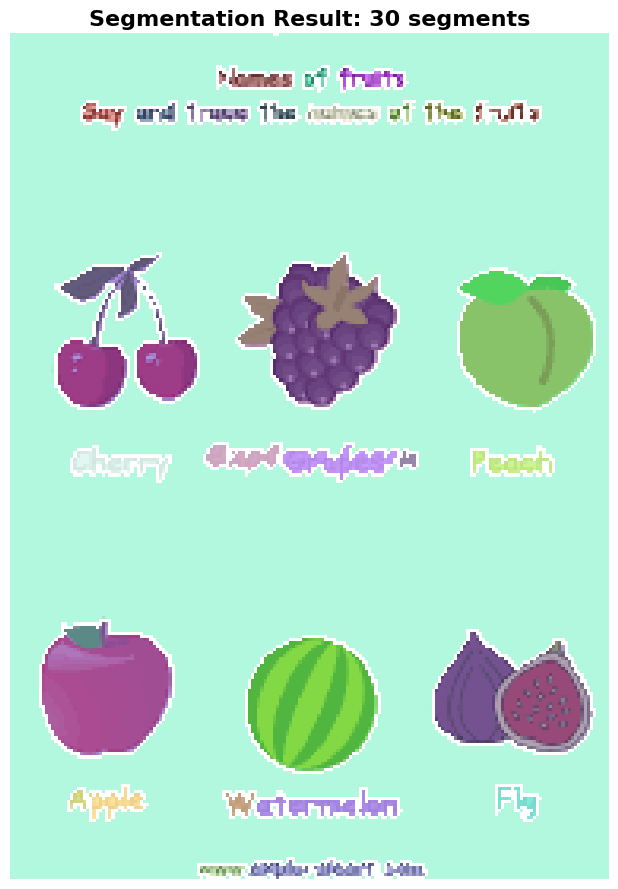

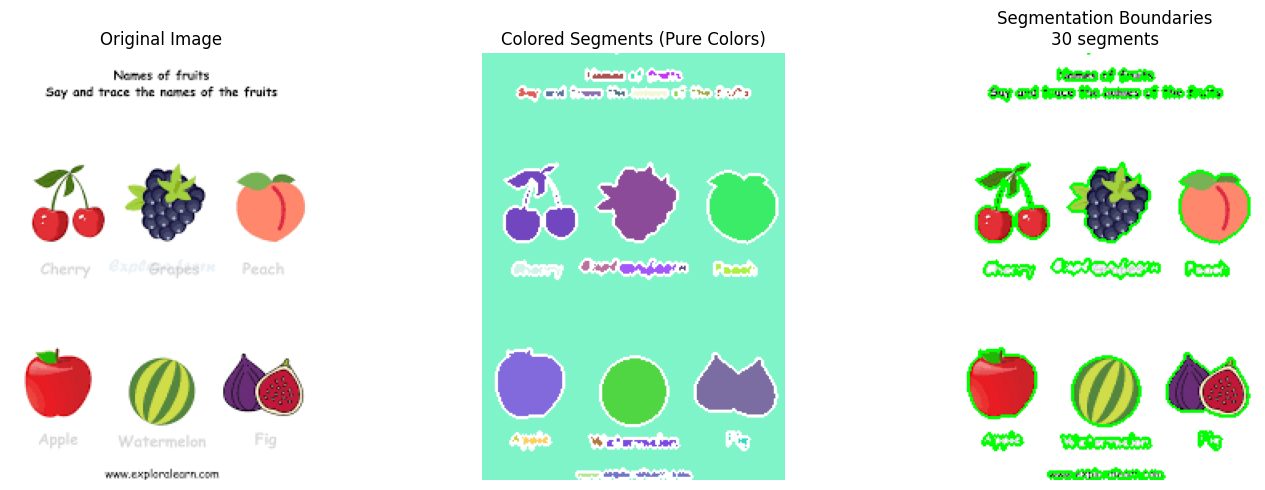

Number of segments: 30


In [ ]:
image=ski.io.imread('./fruits.png')
visualize_segmentation(image, FelzenszwalbSegmentation(image, sigma=0.2, k=50, min_size=20).segment())

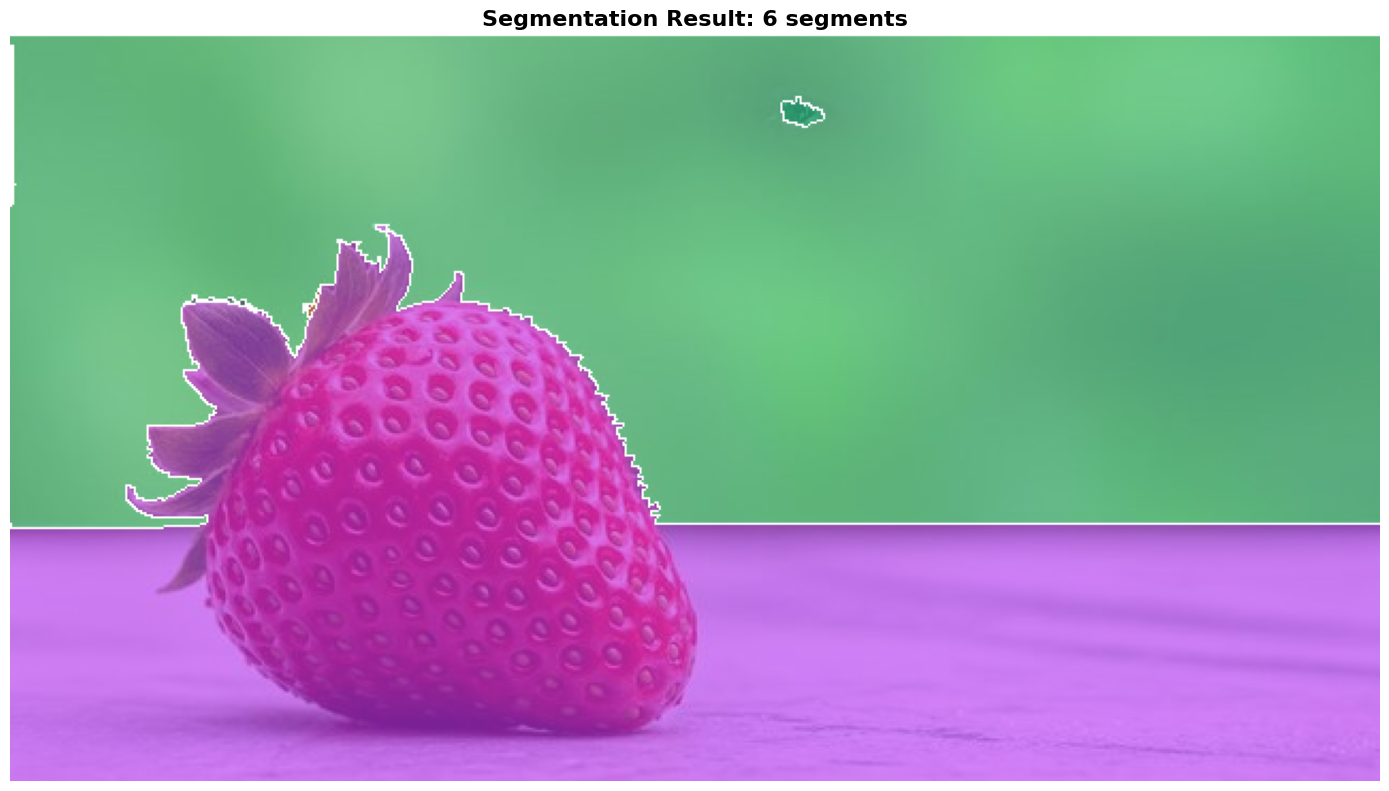

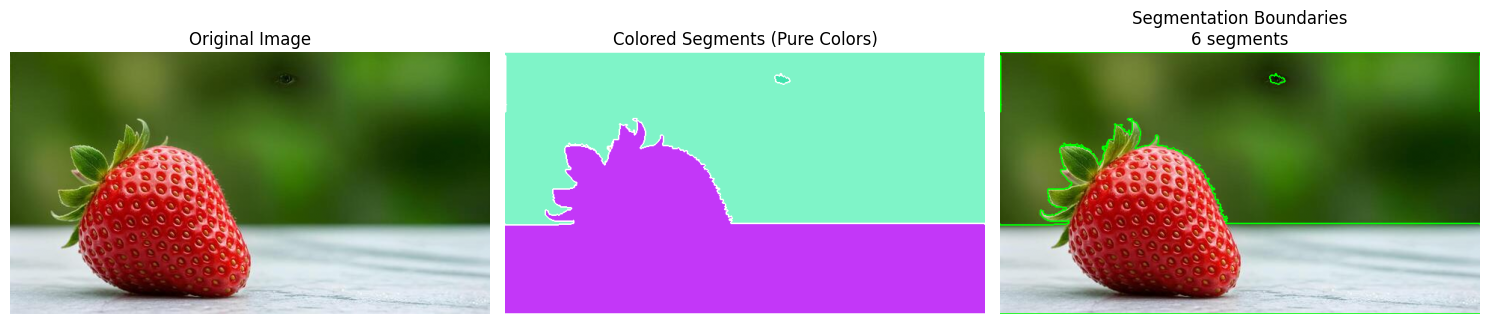

Number of segments: 6


In [26]:
image1=ski.io.imread('./image.jpg')
visualize_segmentation(image1, FelzenszwalbSegmentation(image1, sigma=0.5, k=20, min_size=30).segment())

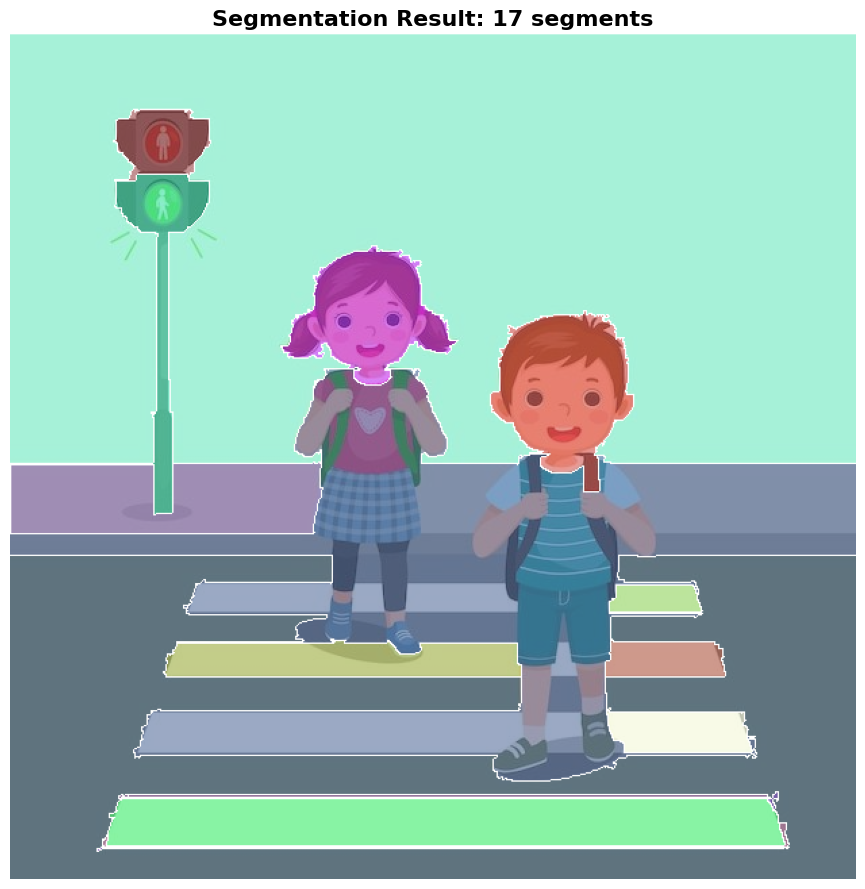

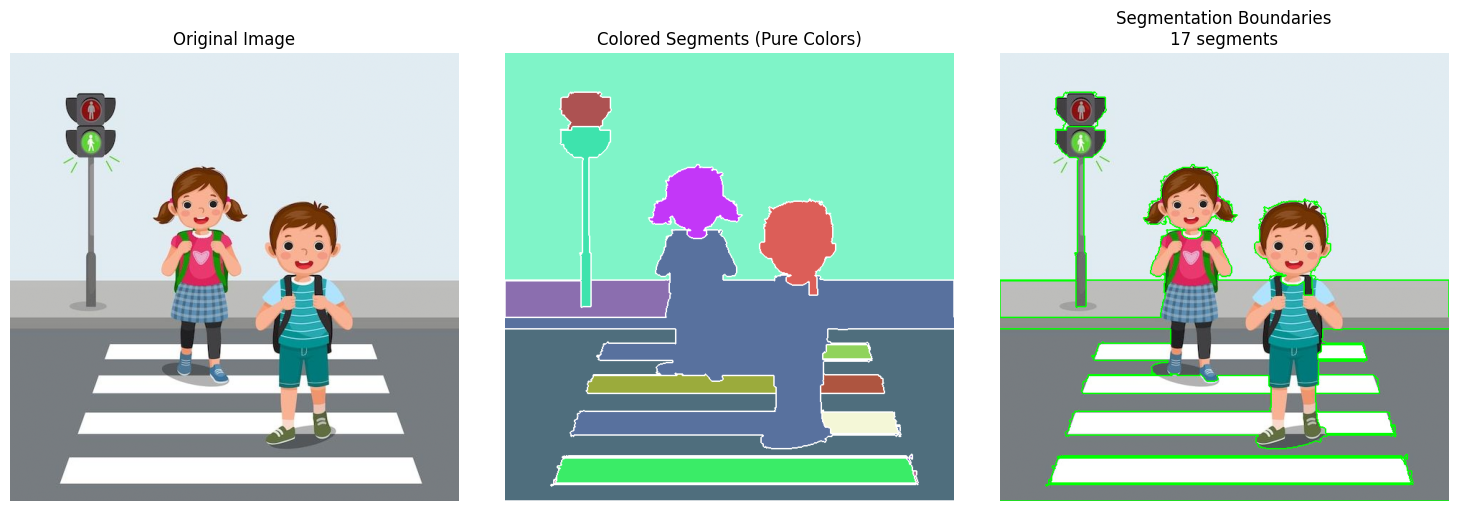

Number of segments: 17


In [34]:
image2=ski.io.imread('./image2.jpg')
visualize_segmentation(image2, FelzenszwalbSegmentation(image2, sigma=0, k=40, min_size=500).segment())